In [1]:
#from bauer.utils.data import load_garcia2022
#from bauer.models import MagnitudeComparisonModel
import numpy as np
import pandas as pd
import seaborn as sns
#from bauer.utils.plotting import plot_ppc
from utils import get_all_behavior, Subject
import os.path as op

bids_folder='/Users/mrenke/data/ds-dnumr'

In [2]:
df = get_all_behavior()

/Users/mrenke/mambaforge/envs/behav_fit2/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


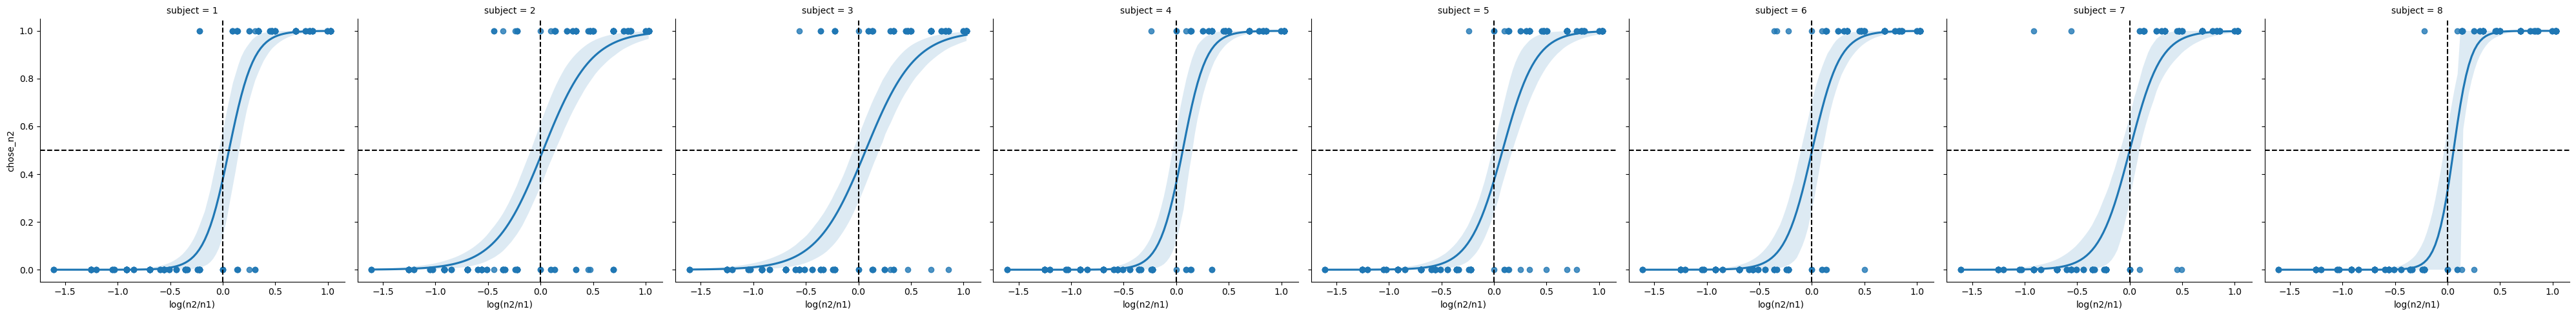

In [10]:
import seaborn as sns

fac = sns.lmplot(x='log(n2/n1)', y='chose_n2', data=df.reset_index(), logistic=True, col='subject')

for ax in fac.axes.ravel():
    ax.axhline(.5, c='k', ls='--')
    ax.axvline(0, c='k', ls='--')

In [11]:
from bauer.models import MagnitudeComparisonModel

df['choice'] = df['chose_n2'] 
model = MagnitudeComparisonModel(df)
model.build_estimation_model()
trace = model.sample(draws=1000, tune=1000)

{'n1_prior_mu': mean, 'n1_prior_std': std, 'n2_prior_std': std, 'threshold': 0.0, 'n1_evidence_mu': Elemwise{log,no_inplace}.0, 'n2_evidence_mu': Elemwise{log,no_inplace}.0, 'n2_prior_mu': AdvancedSubtensor.0, 'n1_evidence_sd': Elemwise{softplus,no_inplace}.0, 'n2_evidence_sd': Elemwise{softplus,no_inplace}.0}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n1_evidence_sd_mu_untransformed, n1_evidence_sd_sd, n1_evidence_sd_offset, n2_evidence_sd_mu_untransformed, n2_evidence_sd_sd, n2_evidence_sd_offset, n2_prior_mu_mu, n2_prior_mu_sd, n2_prior_mu_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


In [12]:
import arviz as az
import matplotlib.pyplot as plt

n2_prior_mu = trace.posterior['n2_prior_mu'].to_dataframe()#.reset_index()
n2_prior_mu = n2_prior_mu.reset_index()
n2_prior_mu['subject'] = pd.Categorical(n2_prior_mu['subject'])

evidence_sd1 = trace.posterior['n1_evidence_sd'].to_dataframe()
evidence_sd2 = trace.posterior['n2_evidence_sd'].to_dataframe()

# evidence_sd = evidence_sd1.join(evidence_sd2)
evidence_sd = pd.concat((evidence_sd1['n1_evidence_sd'], evidence_sd2['n2_evidence_sd']),
keys=['first', 'second'], names=['order'], axis=0).to_frame('evidence_sd')

index_names = evidence_sd.index.names
evidence_sd.reset_index(inplace=True)
evidence_sd['subject'] = pd.Categorical(evidence_sd['subject'])

d1 = pd.DataFrame(evidence_sd.groupby(['subject', 'order']).mean()['evidence_sd'])
d2 = n2_prior_mu.groupby('subject').mean()


params = d1.unstack('order').join(d2['n2_prior_mu'])
params.to_csv('/Users/mrenke/git/numrisk/behavior_simulations/first8-subs_params.csv')


/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_14756/2168631923.py:23: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  params = d1.unstack('order').join(d2['n2_prior_mu'])


In [9]:
params = pd.read_csv('/Users/mrenke/git/numrisk/behavior_simulations/first8-subs_params.csv')
sub_params = pd.DataFrame(data = {'subject': params.iloc[:,0], 'n1_evidence_sd': params.iloc[:,1], 'n2_evidence_sd': params.iloc[:,2], 'n2_prior_mu':params.iloc[:,3]})
sub_params_f8 = sub_params.set_index('subject')

In [10]:
sub_params

,n1_evidence_sd,n2_evidence_sd,n2_prior_mu
subject,,,
1,0.143357,0.172755,0.642357
2,0.338207,0.186191,0.667336
3,0.331737,0.195313,0.617304
4,0.141991,0.169030,0.629805
5,0.181854,0.201477,0.581120
6,0.169320,0.169928,0.724486
7,0.240778,0.172974,0.730517
8,0.129733,0.156654,0.650904
